<a href="https://colab.research.google.com/github/YuichH/ML/blob/main/DL/AE%E3%83%BBDAE%E3%83%BBCNN_%E3%82%A2%E3%83%83%E3%83%97%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通：【Google colabのみ実行】

In [ ]:
# import sys
# # Google colab環境であるか判定
# if 'google.colab' in sys.modules:
#     # ライブラリのインストール
#     !pip install torch==1.10.2 torchvision==0.11.3
# else:
#     print("Not Google Colab")

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Mounted at /content/drive


In [ ]:
import os
data_path = "/content/drive/MyDrive/Ecode/data"
os.makedirs(data_path, exist_ok=True)
model_path = "/content/drive/MyDrive/Ecode/model"
os.makedirs(model_path, exist_ok=True)
result_path = "/content/drive/MyDrive/Ecode/result"
os.makedirs(result_path, exist_ok=True)

In [ ]:
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"

### 共通：ライブラリのインポート

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torch.autograd as autograd
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tqdm
import cv2
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rng = np.random.RandomState(1234)
random_state = 42

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.5)
parser.add_argument("--model_name", default="DAE")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='DAE', n_epoch=15, rate=0.5)


### 共通：Cifar10、低解像度化（縮小して拡大）

In [ ]:
# CIFAR10
transform = transforms.Compose([
    transforms.ToTensor()                      # Torchテンソルに変換
    # , transforms.Normalize(0.5, 0.5)      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)
print(len(dataset_train))

50000


In [ ]:
print(len(dataset_train[49999]))     #(画像データ, ラベル)
print(dataset_train[0][0].shape) #画像データ
print(dataset_train[0][1])       #ラベル
print(type(dataset_train), type(dataset_train[0]), type(dataset_train[0][0]), type(dataset_train[0][1]))

2
torch.Size([3, 32, 32])
6
<class 'torchvision.datasets.cifar.CIFAR10'> <class 'tuple'> <class 'torch.Tensor'> <class 'int'>


In [ ]:
dataset_train[0][0].dtype

torch.float32

入力用に画質を落としたデータ(説明変数)を作成して、元データ(目的変数)とペアのデータセットを作成

縮小した(画質を落とした)あと、元データと同じサイズにすることでコーディングのしやすさと精度向上を狙う

In [ ]:
def lower_resolution(dataset, rate):
  C, H, W = dataset[0][0].shape              #チャンネル数、縦、横
  xtrain = torch.zeros(len(dataset), C, H, W, dtype=torch.float)
  lower_xtrain = torch.zeros(len(dataset), C, H, W, dtype=torch.float)
  for i in tqdm.tqdm(range(len(dataset))):
    xtrain[i] = dataset[i][0]
    tmp = TF.resize(img=dataset[i][0]  , size=(int(H*rate), int(W*rate)))
    lower_xtrain[i] = TF.resize(img=tmp, size=(int(H)     , int(W)), interpolation=T.InterpolationMode.NEAREST)
  return torch.utils.data.TensorDataset(lower_xtrain, xtrain)

In [ ]:
def lower_resolution2(dataset, rate):
  C, H, W = dataset[0][0].shape              #チャンネル数、縦、横
  xtrain = torch.zeros(len(dataset), C, H, W, dtype=torch.float)
  lower_xtrain = torch.zeros(len(dataset), C, H, W, dtype=torch.float)
  for i in tqdm.tqdm(range(len(dataset))):
    xtrain[i] = dataset[i][0]
    tmp = TF.resize(img=dataset[i][0]  , size=(int(H*rate), int(W*rate)))
    lower_xtrain[i] = TF.resize(img=tmp, size=(int(H)     , int(W)), interpolation=T.InterpolationMode.BICUBIC)
  return torch.utils.data.TensorDataset(lower_xtrain, xtrain)

###AE、DAE(Denoising Autoencoder)
画質を落とした画像をAEに入力して、AEの出力と元画像の誤差を計算することで、元画像に近づけることを試みる

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：MSELoss（平均二乗誤差）
*   オプティマイザ：Adam

⇒実行時間：1epochあたり5分

　かなりぼやけた輪郭のない画像が出力された

(net2)

データセット

In [ ]:
lower_dataset_xtrain = lower_resolution(dataset_train, rate=0.5)
print(len(lower_dataset_xtrain))
print(len(lower_dataset_xtrain[49999])) #(縮小データ, 元画像データ)
print(lower_dataset_xtrain[0][0].shape) #縮小データ
print(lower_dataset_xtrain[0][1].shape) #元画像データ
print(type(lower_dataset_xtrain), type(lower_dataset_xtrain[0]), type(lower_dataset_xtrain[0][0]), type(lower_dataset_xtrain[0][1]))

50000
2
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
<class 'torch.utils.data.dataset.TensorDataset'> <class 'tuple'> <class 'torch.Tensor'> <class 'torch.Tensor'>


データローダー

In [ ]:
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
x_train, x_target = next(iter(loader_xtrain))

In [ ]:
print(x_train.shape, x_target.shape)

torch.Size([64, 3, 32, 32]) torch.Size([64, 3, 32, 32])


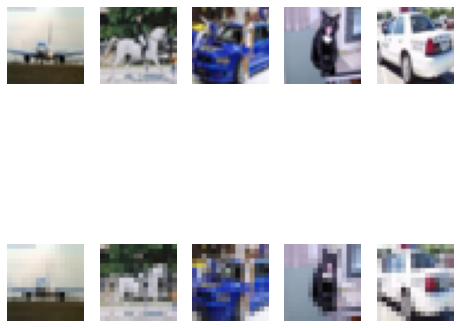

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
class DAE(nn.Module):
    def __init__(self, input_size):
        super(DAE, self).__init__()
        self.enc1 = nn.Linear(input_size     , input_size // 2)
        self.enc2 = nn.Linear(input_size // 2, input_size // 4)
        self.enc3 = nn.Linear(input_size // 4, input_size // 8)
        self.enc4 = nn.Linear(input_size // 8, input_size //16)
        self.dec1 = nn.Linear(input_size //16, input_size // 8)
        self.dec2 = nn.Linear(input_size // 8, input_size // 4)
        self.dec3 = nn.Linear(input_size // 4, input_size // 2)
        self.dec4 = nn.Linear(input_size // 2 , input_size)

    def _encoder(self, x):
      x = F.relu(self.enc1(x))
      x = F.relu(self.enc2(x))
      x = F.relu(self.enc3(x))
      x = self.enc4(x)
      return x

    def _decoder(self, x):
      x = F.relu(self.dec1(x))
      x = F.relu(self.dec2(x))
      x = F.relu(self.dec3(x))
      x = torch.sigmoid(self.dec4(x))
      return x

    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x

    def loss(self, x, target):
        y = self._encoder(x)
        y = self._decoder(y)
        mseloss = criterion(y, target)
        return mseloss

    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))
B, C, H, W = x_train.shape
input_size=C*H*W
net = DAE(input_size).to(device)

In [ ]:
print(x_train.shape)

torch.Size([64, 3, 32, 32])


In [ ]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.reshape(-1, input_size).to(device)
    target_imgs = target_imgs.reshape(-1, input_size).to(device)
    batch_size  = train_imgs.shape[0]

    net.zero_grad()           #勾配初期化
    mse_loss = net.loss(train_imgs, target_imgs)
    loss = mse_loss

    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [03:24<00:00,  3.82it/s]


epoch:0, loss:0.03561630768372732


100%|██████████| 782/782 [04:54<00:00,  2.66it/s]


epoch:1, loss:0.029298456723961377


100%|██████████| 782/782 [04:55<00:00,  2.65it/s]


epoch:2, loss:0.024750895802970126


100%|██████████| 782/782 [04:54<00:00,  2.66it/s]


epoch:3, loss:0.022736144283086138


100%|██████████| 782/782 [04:56<00:00,  2.63it/s]


epoch:4, loss:0.021136560403477507


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


epoch:5, loss:0.020468956719407492


100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


epoch:6, loss:0.019737504794240912


100%|██████████| 782/782 [04:56<00:00,  2.64it/s]


epoch:7, loss:0.018823721516362923


100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


epoch:8, loss:0.01803108174330019


100%|██████████| 782/782 [04:53<00:00,  2.66it/s]


epoch:9, loss:0.017218797718939347


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


epoch:10, loss:0.016555720705615208


100%|██████████| 782/782 [04:54<00:00,  2.66it/s]


epoch:11, loss:0.016126674221223578


100%|██████████| 782/782 [05:00<00:00,  2.60it/s]


epoch:12, loss:0.01592875574417698


100%|██████████| 782/782 [05:16<00:00,  2.47it/s]


epoch:13, loss:0.015812611931463338


100%|██████████| 782/782 [05:21<00:00,  2.44it/s]

epoch:14, loss:0.015498517671852466


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

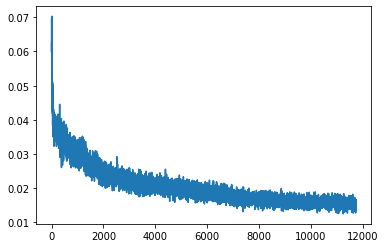

In [ ]:
plt.plot(raw_losses)

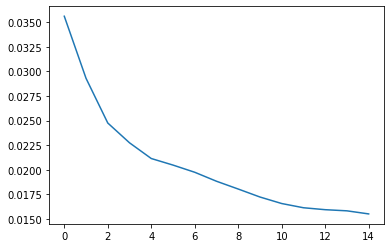

In [ ]:
plt.plot(losses)

In [ ]:
net2 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net2 = net2.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_xtest_050= lower_resolution(dataset_test, rate=0.5)
loader_xtest_x050 = torch.utils.data.DataLoader(lower_xtest_050, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest_x050))

100%|██████████| 10000/10000 [00:05<00:00, 1909.83it/s]


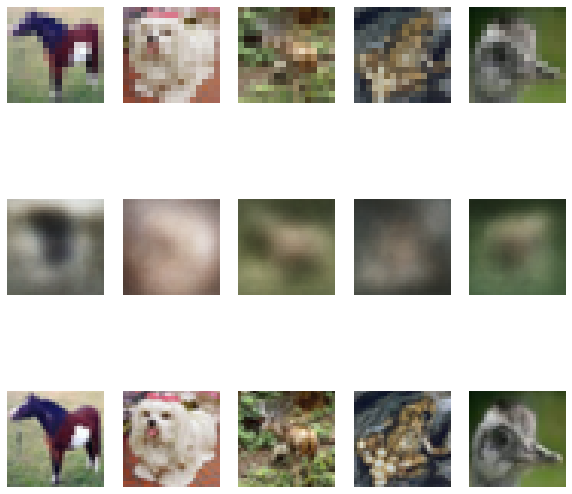

In [ ]:
# AEで再構成したイメージ
fig = plt.figure(figsize=(10, 10))
net2.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net2(x.view(-1, input_size))
  img = y.view(-1, H, W).permute(1, 2, 0).cpu().squeeze().detach().numpy()
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

###AE、DAE(Denoising Autoencoder)
損失関数をChapter7のreconstraction lossに変えてみる

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：reconstraction loss（どれだけ正確に復元できたか）
*   オプティマイザ：Adam

⇒実行時間：1epochあたり5分

　損失関数を変えても大して変わらず

(net3)

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.5)
parser.add_argument("--model_name", default="DAE_reconstraction_loss")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='DAE_reconstraction_loss', n_epoch=15, rate=0.5)


In [ ]:
# 学習データに適用する前処理
transform = transforms.Compose([
    transforms.ToTensor()                      # Torchテンソルに変換
    # , transforms.Normalize(0.5, 0.5)      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)

100%|██████████| 50000/50000 [00:21<00:00, 2344.91it/s]


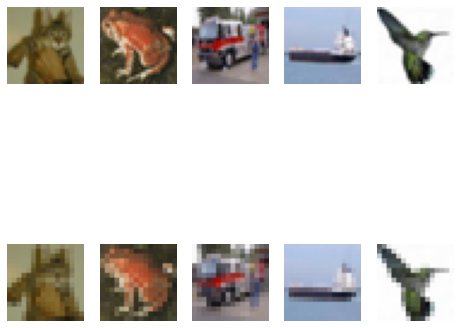

In [ ]:
lower_dataset_xtrain = lower_resolution(dataset_train, rate=0.5)
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))

plt.figure(figsize=(8, 8))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
B, C, H, W = x_train.shape
input_size=C*H*W

In [ ]:
class DAE(nn.Module):
    def __init__(self, input_size):
        super(DAE, self).__init__()
        self.enc1 = nn.Linear(input_size     , input_size // 2)
        self.enc2 = nn.Linear(input_size // 2, input_size // 4)
        self.enc3 = nn.Linear(input_size // 4, input_size // 8)
        self.enc4 = nn.Linear(input_size // 8, input_size //16)
        self.dec1 = nn.Linear(input_size //16, input_size // 8)
        self.dec2 = nn.Linear(input_size // 8, input_size // 4)
        self.dec3 = nn.Linear(input_size // 4, input_size // 2)
        self.dec4 = nn.Linear(input_size // 2 , input_size)

    def _encoder(self, x):
      x = F.relu(self.enc1(x))
      x = F.relu(self.enc2(x))
      x = F.relu(self.enc3(x))
      x = self.enc4(x)
      return x

    def _decoder(self, x):
      x = F.relu(self.dec1(x))
      x = F.relu(self.dec2(x))
      x = F.relu(self.dec3(x))
      x = torch.sigmoid(self.dec4(x))
      return x

    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x

    def loss(self, x, target):
        y = self._encoder(x)
        y = self._decoder(y)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-target * self.torch_log(y) - (1 - target) * self.torch_log(1 - y), dim=1))
        return reconstruction

    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
net = DAE(input_size).to(device)
# criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.reshape(-1, input_size).to(device)
    target_imgs = target_imgs.reshape(-1, input_size).to(device)
    batch_size  = train_imgs.shape[0]

    net.zero_grad()           #勾配初期化
    reconstruction_loss = net.loss(train_imgs, target_imgs)
    loss = reconstruction_loss

    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [03:16<00:00,  3.99it/s]


epoch:0, loss:1949.2759283899957


100%|██████████| 782/782 [05:08<00:00,  2.53it/s]


epoch:1, loss:1910.6485422431965


100%|██████████| 782/782 [05:20<00:00,  2.44it/s]


epoch:2, loss:1885.9632601140406


100%|██████████| 782/782 [05:14<00:00,  2.48it/s]


epoch:3, loss:1859.28286672919


100%|██████████| 782/782 [05:26<00:00,  2.40it/s]


epoch:4, loss:1847.262063731318


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


epoch:5, loss:1844.1804931328425


100%|██████████| 782/782 [04:58<00:00,  2.62it/s]


epoch:6, loss:1837.8664972251638


100%|██████████| 782/782 [05:05<00:00,  2.56it/s]


epoch:7, loss:1832.233222824838


100%|██████████| 782/782 [04:58<00:00,  2.62it/s]


epoch:8, loss:1828.9154727086996


100%|██████████| 782/782 [05:01<00:00,  2.59it/s]


epoch:9, loss:1822.7501581294457


100%|██████████| 782/782 [05:01<00:00,  2.59it/s]


epoch:10, loss:1819.8826685756674


100%|██████████| 782/782 [05:01<00:00,  2.59it/s]


epoch:11, loss:1816.4740762930087


100%|██████████| 782/782 [05:02<00:00,  2.59it/s]


epoch:12, loss:1812.1612776734335


100%|██████████| 782/782 [05:08<00:00,  2.53it/s]


epoch:13, loss:1807.91424701037


100%|██████████| 782/782 [05:14<00:00,  2.49it/s]

epoch:14, loss:1805.235730105349


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

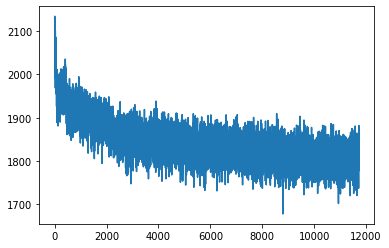

In [ ]:
plt.plot(raw_losses)

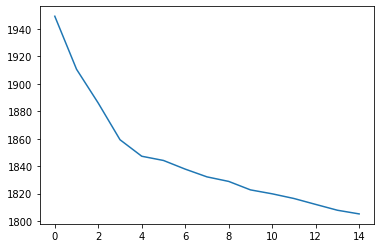

In [ ]:
plt.plot(losses)

In [ ]:
net3 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net3 = net3.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_dataset_xtest= lower_resolution(dataset_test, rate=0.5)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

100%|██████████| 10000/10000 [00:04<00:00, 2327.81it/s]


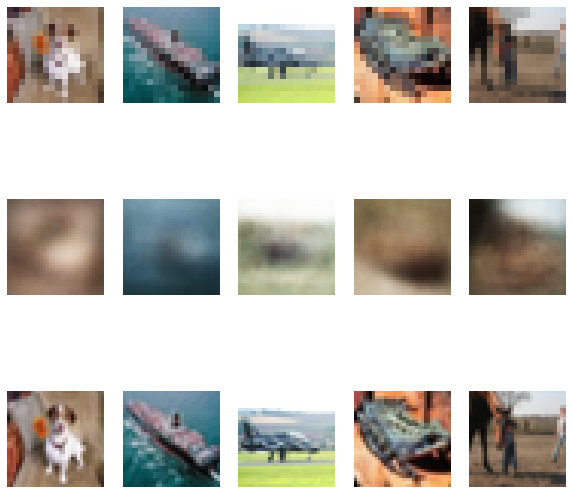

In [ ]:
fig = plt.figure(figsize=(10, 10))
net3.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net3(x.view(-1, input_size))
  img = y.view(-1, H, W).permute(1, 2, 0).cpu().squeeze().detach().numpy()
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

###CNN

Linearでは1次元変換して入力してるのでピクセルの配置とかが無視されてるので、CNNに変えてみる(Chapter5)

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：MSELoss（平均二乗誤差）
*   オプティマイザ：Adam
*   transformsで標準化を実施

⇒実行時間：1epochあたり10s

　実行時間が短い上に、元画像に近づけることができている

(net4)

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.5)
parser.add_argument("--model_name", default="SRCNN")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='SRCNN', n_epoch=15, rate=0.5)


In [ ]:
# 学習データに適用する前処理
transform = transforms.Compose([
    transforms.ToTensor()                                          # Torchテンソルに変換
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)

In [ ]:
lower_dataset_xtrain = lower_resolution(dataset_train, rate=0.5)
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))

100%|██████████| 50000/50000 [00:28<00:00, 1752.42it/s]


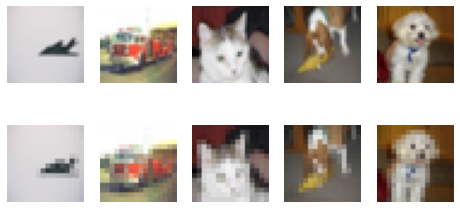

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
B, C, H, W = x_train.shape
input_size=C*H*W

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, input_c=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_c, out_channels=64     , kernel_size=9, padding=9 //2)
        self.conv2 = nn.Conv2d(in_channels=64     , out_channels=32     , kernel_size=5, padding=5 //2)
        self.conv3 = nn.Conv2d(in_channels=32     , out_channels=input_c, kernel_size=5, padding=5 //2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
net = SRCNN(C).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  net.train()
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.to(device)
    target_imgs = target_imgs.to(device)
    batch_size  = train_imgs.shape[0]

    outputs = net(train_imgs)
    loss = criterion(outputs, target_imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [00:15<00:00, 50.90it/s]


epoch:0, loss:0.013170764607656033


100%|██████████| 782/782 [00:09<00:00, 81.62it/s]


epoch:1, loss:0.008989253195712482


100%|██████████| 782/782 [00:09<00:00, 79.44it/s]


epoch:2, loss:0.008575158039479495


100%|██████████| 782/782 [00:10<00:00, 72.25it/s]


epoch:3, loss:0.008300613769737389


100%|██████████| 782/782 [00:10<00:00, 75.17it/s]


epoch:4, loss:0.00815240251581611


100%|██████████| 782/782 [00:09<00:00, 78.63it/s]


epoch:5, loss:0.008055966981636633


100%|██████████| 782/782 [00:09<00:00, 82.76it/s]


epoch:6, loss:0.00795329150403171


100%|██████████| 782/782 [00:09<00:00, 82.83it/s]


epoch:7, loss:0.007894443817284253


100%|██████████| 782/782 [00:09<00:00, 82.91it/s]


epoch:8, loss:0.007838002274460767


100%|██████████| 782/782 [00:09<00:00, 82.80it/s]


epoch:9, loss:0.007793520927391089


100%|██████████| 782/782 [00:09<00:00, 82.02it/s]


epoch:10, loss:0.007737147064446031


100%|██████████| 782/782 [00:09<00:00, 82.37it/s]


epoch:11, loss:0.007711250721441244


100%|██████████| 782/782 [00:09<00:00, 82.22it/s]


epoch:12, loss:0.007674450268540198


100%|██████████| 782/782 [00:09<00:00, 82.07it/s]


epoch:13, loss:0.007644555467726363


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]

epoch:14, loss:0.007616132333436433


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

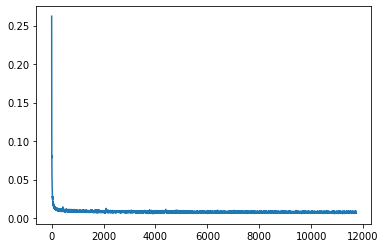

In [ ]:
plt.plot(raw_losses)

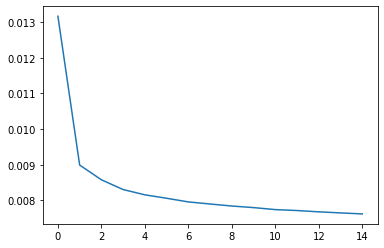

In [ ]:
plt.plot(losses)

In [ ]:
net4 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net4 = net4.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_dataset_xtest= lower_resolution(dataset_test, rate=0.5)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

100%|██████████| 10000/10000 [00:05<00:00, 1853.66it/s]


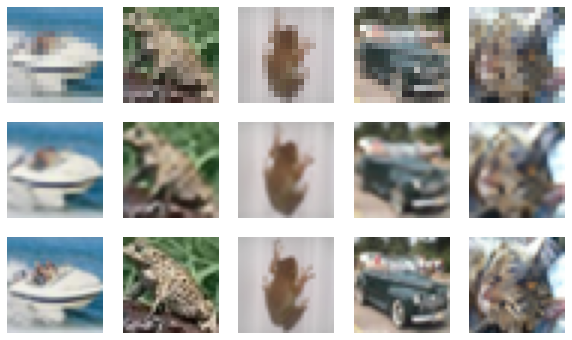

In [ ]:
fig = plt.figure(figsize=(10, 6))
net4.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net4(x)
  img = y[0].permute(1, 2, 0).cpu().detach().numpy()
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

###CNN
画質をさらに落とした画像で(50%→25%)、学習させてみる

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：MSELoss（平均二乗誤差）
*   オプティマイザ：Adam
*   transformsで標準化を実施

⇒実行時間：1epochあたり10s

　500epoch実行しても精度が上がらない

(net5)

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=500)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.25)
parser.add_argument("--model_name", default="SRCNN")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='SRCNN', n_epoch=500, rate=0.25)


In [ ]:
# 学習データに適用する前処理
transform = transforms.Compose([
    transforms.ToTensor()                                          # Torchテンソルに変換
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)

In [ ]:
lower_dataset_xtrain = lower_resolution(dataset_train, rate=opt.rate)
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))

100%|██████████| 50000/50000 [00:27<00:00, 1839.66it/s]


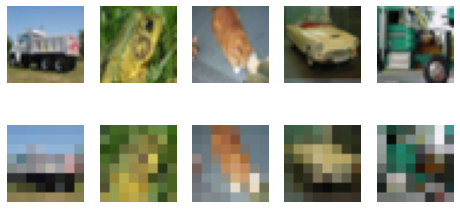

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
B, C, H, W = x_train.shape
input_size=C*H*W

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, input_c=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_c, out_channels=64     , kernel_size=9, padding=9 //2)
        self.conv2 = nn.Conv2d(in_channels=64     , out_channels=32     , kernel_size=5, padding=5 //2)
        self.conv3 = nn.Conv2d(in_channels=32     , out_channels=input_c, kernel_size=5, padding=5 //2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
net = SRCNN(C).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  net.train()
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.to(device)
    target_imgs = target_imgs.to(device)
    batch_size  = train_imgs.shape[0]

    outputs = net(train_imgs)
    loss = criterion(outputs, target_imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [00:09<00:00, 81.03it/s]


epoch:0, loss:0.04192869109161141


100%|██████████| 782/782 [00:09<00:00, 84.44it/s]


epoch:1, loss:0.03867492106412073


100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


epoch:2, loss:0.0382716765012735


100%|██████████| 782/782 [00:09<00:00, 81.64it/s]


epoch:3, loss:0.03803242889740278


100%|██████████| 782/782 [00:09<00:00, 83.77it/s]


epoch:4, loss:0.037979685472767526


100%|██████████| 782/782 [00:09<00:00, 83.40it/s]


epoch:5, loss:0.0378132173196053


100%|██████████| 782/782 [00:09<00:00, 83.32it/s]


epoch:6, loss:0.037751432655907954


100%|██████████| 782/782 [00:09<00:00, 83.17it/s]


epoch:7, loss:0.03767301340866119


100%|██████████| 782/782 [00:09<00:00, 82.94it/s]


epoch:8, loss:0.037594467939813726


100%|██████████| 782/782 [00:09<00:00, 82.27it/s]


epoch:9, loss:0.03752986863112587


100%|██████████| 782/782 [00:09<00:00, 82.31it/s]


epoch:10, loss:0.037484912587629864


100%|██████████| 782/782 [00:09<00:00, 82.38it/s]


epoch:11, loss:0.03742121343436601


100%|██████████| 782/782 [00:09<00:00, 82.24it/s]


epoch:12, loss:0.037360015777809084


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:13, loss:0.037292055749927486


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:14, loss:0.03730532222801386


100%|██████████| 782/782 [00:09<00:00, 82.71it/s]


epoch:15, loss:0.03723787852441487


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:16, loss:0.03722417232392313


100%|██████████| 782/782 [00:09<00:00, 81.26it/s]


epoch:17, loss:0.03716563239522145


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:18, loss:0.037126236187908654


100%|██████████| 782/782 [00:09<00:00, 82.27it/s]


epoch:19, loss:0.03712553401356158


100%|██████████| 782/782 [00:09<00:00, 82.26it/s]


epoch:20, loss:0.03709211561333417


100%|██████████| 782/782 [00:09<00:00, 82.22it/s]


epoch:21, loss:0.037037390624851826


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:22, loss:0.03703839823965679


100%|██████████| 782/782 [00:09<00:00, 82.35it/s]


epoch:23, loss:0.03699093243664564


100%|██████████| 782/782 [00:10<00:00, 75.85it/s]


epoch:24, loss:0.03698692938832142


100%|██████████| 782/782 [00:10<00:00, 78.00it/s]


epoch:25, loss:0.03698246815310948


100%|██████████| 782/782 [00:09<00:00, 82.65it/s]


epoch:26, loss:0.03694179725101994


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:27, loss:0.036954051924540716


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:28, loss:0.03692137406391027


100%|██████████| 782/782 [00:09<00:00, 78.48it/s]


epoch:29, loss:0.03692226397478596


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:30, loss:0.036885971832267765


100%|██████████| 782/782 [00:09<00:00, 81.56it/s]


epoch:31, loss:0.03685914544993654


100%|██████████| 782/782 [00:09<00:00, 82.45it/s]


epoch:32, loss:0.036870367122371024


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:33, loss:0.03686795875077586


100%|██████████| 782/782 [00:09<00:00, 82.70it/s]


epoch:34, loss:0.036825549031329126


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:35, loss:0.0368363831782966


100%|██████████| 782/782 [00:09<00:00, 79.52it/s]


epoch:36, loss:0.03681268151182576


100%|██████████| 782/782 [00:10<00:00, 76.52it/s]


epoch:37, loss:0.03679251405970215


100%|██████████| 782/782 [00:09<00:00, 80.51it/s]


epoch:38, loss:0.036788181120725086


100%|██████████| 782/782 [00:10<00:00, 75.47it/s]


epoch:39, loss:0.03679265856237896


100%|██████████| 782/782 [00:09<00:00, 81.46it/s]


epoch:40, loss:0.036755920204398274


100%|██████████| 782/782 [00:10<00:00, 73.21it/s]


epoch:41, loss:0.03674931367120855


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:42, loss:0.0367390284257586


100%|██████████| 782/782 [00:10<00:00, 77.66it/s]


epoch:43, loss:0.03672783789665574


100%|██████████| 782/782 [00:09<00:00, 82.27it/s]


epoch:44, loss:0.03674196653887439


100%|██████████| 782/782 [00:09<00:00, 81.62it/s]


epoch:45, loss:0.03674895560268856


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:46, loss:0.036718744086697126


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:47, loss:0.03671722934650414


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:48, loss:0.036690136389163755


100%|██████████| 782/782 [00:09<00:00, 82.71it/s]


epoch:49, loss:0.03668269445486081


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:50, loss:0.03667508265541871


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:51, loss:0.0366785422543926


100%|██████████| 782/782 [00:09<00:00, 82.82it/s]


epoch:52, loss:0.036679345928608914


100%|██████████| 782/782 [00:09<00:00, 82.18it/s]


epoch:53, loss:0.036663248384719155


100%|██████████| 782/782 [00:09<00:00, 82.23it/s]


epoch:54, loss:0.036663127181780004


100%|██████████| 782/782 [00:09<00:00, 82.41it/s]


epoch:55, loss:0.03664261702676792


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:56, loss:0.03663398594359684


100%|██████████| 782/782 [00:09<00:00, 81.69it/s]


epoch:57, loss:0.036640046397819544


100%|██████████| 782/782 [00:09<00:00, 80.50it/s]


epoch:58, loss:0.036633509339864756


100%|██████████| 782/782 [00:10<00:00, 74.76it/s]


epoch:59, loss:0.03661434199956372


100%|██████████| 782/782 [00:09<00:00, 79.47it/s]


epoch:60, loss:0.036623298331066166


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:61, loss:0.036603751623302774


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:62, loss:0.036617217773614485


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:63, loss:0.03659032495296977


100%|██████████| 782/782 [00:09<00:00, 82.25it/s]


epoch:64, loss:0.03658863582917492


100%|██████████| 782/782 [00:09<00:00, 81.24it/s]


epoch:65, loss:0.036585665388923626


100%|██████████| 782/782 [00:10<00:00, 78.06it/s]


epoch:66, loss:0.03656300661318442


100%|██████████| 782/782 [00:09<00:00, 80.42it/s]


epoch:67, loss:0.03655083577536866


100%|██████████| 782/782 [00:10<00:00, 77.57it/s]


epoch:68, loss:0.03658314830506854


100%|██████████| 782/782 [00:09<00:00, 80.90it/s]


epoch:69, loss:0.036548838398093


100%|██████████| 782/782 [00:09<00:00, 81.02it/s]


epoch:70, loss:0.03655464990336038


100%|██████████| 782/782 [00:10<00:00, 74.04it/s]


epoch:71, loss:0.03653990561642763


100%|██████████| 782/782 [00:09<00:00, 78.26it/s]


epoch:72, loss:0.03653645509248957


100%|██████████| 782/782 [00:10<00:00, 74.99it/s]


epoch:73, loss:0.03652600059881235


100%|██████████| 782/782 [00:10<00:00, 75.54it/s]


epoch:74, loss:0.03653689286173762


100%|██████████| 782/782 [00:10<00:00, 75.72it/s]


epoch:75, loss:0.036532450114827024


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:76, loss:0.03654451463180963


100%|██████████| 782/782 [00:09<00:00, 82.45it/s]


epoch:77, loss:0.03651953288985183


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:78, loss:0.03651427448777211


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:79, loss:0.03650860805921923


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:80, loss:0.036508502467247225


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:81, loss:0.036496019855503686


100%|██████████| 782/782 [00:09<00:00, 82.06it/s]


epoch:82, loss:0.036509983513094584


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:83, loss:0.03649746143804563


100%|██████████| 782/782 [00:09<00:00, 82.65it/s]


epoch:84, loss:0.03651224741059572


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:85, loss:0.0364864760309534


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:86, loss:0.036476031510288


100%|██████████| 782/782 [00:09<00:00, 82.70it/s]


epoch:87, loss:0.03649523910230307


100%|██████████| 782/782 [00:09<00:00, 82.23it/s]


epoch:88, loss:0.036481544027662335


100%|██████████| 782/782 [00:09<00:00, 81.00it/s]


epoch:89, loss:0.03646678192412381


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:90, loss:0.036462140043297085


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:91, loss:0.03645711761834981


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:92, loss:0.03648338045286553


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:93, loss:0.03648013748047526


100%|██████████| 782/782 [00:09<00:00, 82.38it/s]


epoch:94, loss:0.036455493672843786


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


epoch:95, loss:0.03645503845142053


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:96, loss:0.036423417861047


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:97, loss:0.036427526877683296


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:98, loss:0.036439961606107865


100%|██████████| 782/782 [00:09<00:00, 81.27it/s]


epoch:99, loss:0.03644619976429988


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:100, loss:0.0364433967334497


100%|██████████| 782/782 [00:09<00:00, 82.35it/s]


epoch:101, loss:0.036416438517763335


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:102, loss:0.03643400067715998


100%|██████████| 782/782 [00:09<00:00, 82.71it/s]


epoch:103, loss:0.03642833755944696


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:104, loss:0.03642459644381043


100%|██████████| 782/782 [00:09<00:00, 82.30it/s]


epoch:105, loss:0.03642622435279667


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:106, loss:0.03644723608098981


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:107, loss:0.0364362732328646


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:108, loss:0.036401396002763375


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:109, loss:0.03640008565333798


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:110, loss:0.03642627726668668


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:111, loss:0.036388697386111904


100%|██████████| 782/782 [00:09<00:00, 82.37it/s]


epoch:112, loss:0.036417442566865244


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:113, loss:0.0363974729576684


100%|██████████| 782/782 [00:09<00:00, 81.37it/s]


epoch:114, loss:0.036405303903743434


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:115, loss:0.03638207932453021


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:116, loss:0.036393786237463165


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:117, loss:0.036378781296922576


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:118, loss:0.036379987943221996


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:119, loss:0.036386862887865135


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:120, loss:0.0363851840110005


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:121, loss:0.036369317980564156


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:122, loss:0.0363832400073214


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:123, loss:0.03639642493870786


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:124, loss:0.036364655467726846


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:125, loss:0.03636355673098732


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:126, loss:0.03638307981507476


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:127, loss:0.03636760041212944


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:128, loss:0.03636227046970821


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:129, loss:0.03638046733139421


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:130, loss:0.0363620546982264


100%|██████████| 782/782 [00:09<00:00, 82.48it/s]


epoch:131, loss:0.03636407090441498


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:132, loss:0.03634553329537973


100%|██████████| 782/782 [00:09<00:00, 82.19it/s]


epoch:133, loss:0.03635877964880003


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:134, loss:0.03634108845954356


100%|██████████| 782/782 [00:09<00:00, 79.36it/s]


epoch:135, loss:0.03635073700429076


100%|██████████| 782/782 [00:09<00:00, 80.81it/s]


epoch:136, loss:0.03634184119446427


100%|██████████| 782/782 [00:09<00:00, 81.66it/s]


epoch:137, loss:0.03633609196156873


100%|██████████| 782/782 [00:09<00:00, 81.44it/s]


epoch:138, loss:0.036320252165369826


100%|██████████| 782/782 [00:09<00:00, 82.15it/s]


epoch:139, loss:0.03632660165829275


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:140, loss:0.03633453661952254


100%|██████████| 782/782 [00:09<00:00, 82.30it/s]


epoch:141, loss:0.03632929748700708


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


epoch:142, loss:0.0363330784113244


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:143, loss:0.036324739241805834


100%|██████████| 782/782 [00:09<00:00, 82.76it/s]


epoch:144, loss:0.03631649626528516


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:145, loss:0.0363197235885979


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:146, loss:0.036342298771585804


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:147, loss:0.0363300948420449


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:148, loss:0.03631545135708492


100%|██████████| 782/782 [00:09<00:00, 79.29it/s]


epoch:149, loss:0.036302686252100085


100%|██████████| 782/782 [00:10<00:00, 76.81it/s]


epoch:150, loss:0.03629300682126637


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:151, loss:0.036317412700989975


100%|██████████| 782/782 [00:09<00:00, 82.83it/s]


epoch:152, loss:0.03632853380011399


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:153, loss:0.03631295309737896


100%|██████████| 782/782 [00:09<00:00, 81.99it/s]


epoch:154, loss:0.036303586733844276


100%|██████████| 782/782 [00:10<00:00, 76.90it/s]


epoch:155, loss:0.036309988892939696


100%|██████████| 782/782 [00:10<00:00, 74.94it/s]


epoch:156, loss:0.036294580439624885


100%|██████████| 782/782 [00:10<00:00, 74.90it/s]


epoch:157, loss:0.03632475526484154


100%|██████████| 782/782 [00:09<00:00, 78.46it/s]


epoch:158, loss:0.03629758079176593


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:159, loss:0.036303677548513845


100%|██████████| 782/782 [00:09<00:00, 82.34it/s]


epoch:160, loss:0.036282382367174036


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:161, loss:0.03628326171670881


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:162, loss:0.03629436907942033


100%|██████████| 782/782 [00:10<00:00, 78.12it/s]


epoch:163, loss:0.036287738524777506


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:164, loss:0.036263053207789234


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:165, loss:0.03629300570177377


100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


epoch:166, loss:0.03628590420040938


100%|██████████| 782/782 [00:09<00:00, 82.77it/s]


epoch:167, loss:0.03629703898830792


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:168, loss:0.036287972822671044


100%|██████████| 782/782 [00:09<00:00, 82.57it/s]


epoch:169, loss:0.03628267806566432


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:170, loss:0.03628205687588895


100%|██████████| 782/782 [00:09<00:00, 82.31it/s]


epoch:171, loss:0.03629424165496055


100%|██████████| 782/782 [00:09<00:00, 82.12it/s]


epoch:172, loss:0.036260520401017744


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:173, loss:0.036262101041215


100%|██████████| 782/782 [00:09<00:00, 82.25it/s]


epoch:174, loss:0.03626974109236313


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:175, loss:0.036281345929007246


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:176, loss:0.03627283623694535


100%|██████████| 782/782 [00:09<00:00, 82.79it/s]


epoch:177, loss:0.0362555577331568


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:178, loss:0.0362662401055093


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:179, loss:0.0362566024412775


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:180, loss:0.036274838297034775


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:181, loss:0.03626311268142956


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:182, loss:0.03625831759446646


100%|██████████| 782/782 [00:09<00:00, 82.65it/s]


epoch:183, loss:0.036271775886892815


100%|██████████| 782/782 [00:09<00:00, 82.83it/s]


epoch:184, loss:0.036255522002287384


100%|██████████| 782/782 [00:09<00:00, 82.79it/s]


epoch:185, loss:0.036275665887900634


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:186, loss:0.03626851116776314


100%|██████████| 782/782 [00:09<00:00, 82.72it/s]


epoch:187, loss:0.0362429616501188


100%|██████████| 782/782 [00:09<00:00, 81.25it/s]


epoch:188, loss:0.03624405969372567


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:189, loss:0.036242856079583885


100%|██████████| 782/782 [00:09<00:00, 82.76it/s]


epoch:190, loss:0.03624313207738616


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:191, loss:0.036256958347033054


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:192, loss:0.03624041215576174


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:193, loss:0.036238199426218524


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:194, loss:0.03624216408547386


100%|██████████| 782/782 [00:09<00:00, 82.78it/s]


epoch:195, loss:0.036259844237009585


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:196, loss:0.03622878554379544


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:197, loss:0.03623459563183282


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:198, loss:0.03621349019496261


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:199, loss:0.03622256534274124


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:200, loss:0.03623863723834076


100%|██████████| 782/782 [00:09<00:00, 82.81it/s]


epoch:201, loss:0.03624151826447919


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:202, loss:0.03622789236257219


100%|██████████| 782/782 [00:09<00:00, 82.81it/s]


epoch:203, loss:0.036223307078051596


100%|██████████| 782/782 [00:09<00:00, 82.57it/s]


epoch:204, loss:0.03620656756469813


100%|██████████| 782/782 [00:09<00:00, 82.81it/s]


epoch:205, loss:0.03620242530865895


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:206, loss:0.0362223327574332


100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


epoch:207, loss:0.03623190057961761


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:208, loss:0.03622321167108043


100%|██████████| 782/782 [00:09<00:00, 82.87it/s]


epoch:209, loss:0.03623030139633533


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:210, loss:0.03622041217735052


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:211, loss:0.03619854077172782


100%|██████████| 782/782 [00:09<00:00, 81.30it/s]


epoch:212, loss:0.036220122852822396


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:213, loss:0.036220166191477755


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:214, loss:0.03622675568217893


100%|██████████| 782/782 [00:09<00:00, 82.45it/s]


epoch:215, loss:0.03619354245636393


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:216, loss:0.03621964519152708


100%|██████████| 782/782 [00:09<00:00, 82.80it/s]


epoch:217, loss:0.036185042794479434


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:218, loss:0.03621860581409672


100%|██████████| 782/782 [00:09<00:00, 82.77it/s]


epoch:219, loss:0.03622003463442292


100%|██████████| 782/782 [00:09<00:00, 80.69it/s]


epoch:220, loss:0.03621560604552097


100%|██████████| 782/782 [00:09<00:00, 81.72it/s]


epoch:221, loss:0.03620813448039238


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:222, loss:0.03622018370796424


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:223, loss:0.03619664326986617


100%|██████████| 782/782 [00:09<00:00, 82.91it/s]


epoch:224, loss:0.03622969915694974


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:225, loss:0.0362047592911612


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:226, loss:0.036199697855469365


100%|██████████| 782/782 [00:09<00:00, 82.84it/s]


epoch:227, loss:0.036202347225240426


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:228, loss:0.03619784832743885


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:229, loss:0.0362077866850035


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:230, loss:0.03620355039634897


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:231, loss:0.03620670670810182


100%|██████████| 782/782 [00:09<00:00, 82.65it/s]


epoch:232, loss:0.03618562358724492


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:233, loss:0.03621961877626531


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:234, loss:0.03618519197044241


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:235, loss:0.0362020038387469


100%|██████████| 782/782 [00:09<00:00, 82.78it/s]


epoch:236, loss:0.0361909353533936


100%|██████████| 782/782 [00:09<00:00, 81.45it/s]


epoch:237, loss:0.036183906657159176


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:238, loss:0.03618530426031488


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:239, loss:0.036179119089851754


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:240, loss:0.036201087534046536


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:241, loss:0.036169615362192056


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:242, loss:0.03619587027212924


100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


epoch:243, loss:0.03618402271281423


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:244, loss:0.03618501272776624


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:245, loss:0.03618743955193426


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:246, loss:0.03616700307859103


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:247, loss:0.036169883035256735


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:248, loss:0.03617852002553775


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:249, loss:0.03618252828783925


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:250, loss:0.03616708928190381


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:251, loss:0.036183203349028095


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:252, loss:0.03617383616612009


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:253, loss:0.03616934714367247


100%|██████████| 782/782 [00:09<00:00, 82.75it/s]


epoch:254, loss:0.036157195346758646


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:255, loss:0.036157474179020925


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:256, loss:0.03617738909743098


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:257, loss:0.03615157016317177


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:258, loss:0.03620068658657772


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:259, loss:0.036196839438317835


100%|██████████| 782/782 [00:09<00:00, 82.72it/s]


epoch:260, loss:0.03616209210985152


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:261, loss:0.036183078654224765


100%|██████████| 782/782 [00:09<00:00, 81.34it/s]


epoch:262, loss:0.03616479473412418


100%|██████████| 782/782 [00:09<00:00, 82.23it/s]


epoch:263, loss:0.036164691221550145


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:264, loss:0.0361740408069871


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:265, loss:0.03616688996934525


100%|██████████| 782/782 [00:09<00:00, 82.84it/s]


epoch:266, loss:0.03615148959066862


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:267, loss:0.036157196466251255


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:268, loss:0.036181780740694926


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:269, loss:0.03615521221324001


100%|██████████| 782/782 [00:09<00:00, 82.70it/s]


epoch:270, loss:0.036155765985741335


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:271, loss:0.03614610431434782


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:272, loss:0.03614533204785393


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:273, loss:0.03614187756281756


100%|██████████| 782/782 [00:09<00:00, 82.37it/s]


epoch:274, loss:0.03617584356404555


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:275, loss:0.03615368030669973


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:276, loss:0.036160573289465266


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:277, loss:0.03613358192488818


100%|██████████| 782/782 [00:09<00:00, 82.62it/s]


epoch:278, loss:0.03615340239385052


100%|██████████| 782/782 [00:09<00:00, 82.79it/s]


epoch:279, loss:0.03616366440625599


100%|██████████| 782/782 [00:09<00:00, 82.63it/s]


epoch:280, loss:0.03614436130484809


100%|██████████| 782/782 [00:09<00:00, 82.78it/s]


epoch:281, loss:0.036126458926883806


100%|██████████| 782/782 [00:09<00:00, 82.84it/s]


epoch:282, loss:0.036145086424029846


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:283, loss:0.0361563657241328


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:284, loss:0.03614132205152984


100%|██████████| 782/782 [00:09<00:00, 82.74it/s]


epoch:285, loss:0.036128098519085466


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:286, loss:0.03613595047351116


100%|██████████| 782/782 [00:09<00:00, 81.42it/s]


epoch:287, loss:0.03613372528425339


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:288, loss:0.036121079731551584


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:289, loss:0.036149014954638604


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:290, loss:0.03615255985656739


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:291, loss:0.036140462426502075


100%|██████████| 782/782 [00:09<00:00, 82.48it/s]


epoch:292, loss:0.03612161962472645


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:293, loss:0.03615646696913882


100%|██████████| 782/782 [00:09<00:00, 82.71it/s]


epoch:294, loss:0.03613548707026426


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:295, loss:0.03612938713606285


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:296, loss:0.036152900072753125


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:297, loss:0.03611584081340705


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


epoch:298, loss:0.03612525042270303


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:299, loss:0.03613522694781994


100%|██████████| 782/782 [00:09<00:00, 81.49it/s]


epoch:300, loss:0.036125850075346126


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:301, loss:0.03612822902810467


100%|██████████| 782/782 [00:09<00:00, 82.32it/s]


epoch:302, loss:0.03613659203805201


100%|██████████| 782/782 [00:09<00:00, 82.38it/s]


epoch:303, loss:0.03614118056910117


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:304, loss:0.036111214510200884


100%|██████████| 782/782 [00:09<00:00, 82.60it/s]


epoch:305, loss:0.036125692162576994


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:306, loss:0.03612841017391828


100%|██████████| 782/782 [00:09<00:00, 82.57it/s]


epoch:307, loss:0.03612709100908407


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:308, loss:0.03610730139286165


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:309, loss:0.03613357267597371


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:310, loss:0.036129581384703784


100%|██████████| 782/782 [00:09<00:00, 81.17it/s]


epoch:311, loss:0.03611148431982912


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:312, loss:0.03612671071744483


100%|██████████| 782/782 [00:09<00:00, 82.48it/s]


epoch:313, loss:0.03611560278784131


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:314, loss:0.03613959269507614


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:315, loss:0.03613378440060884


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:316, loss:0.03610556207054183


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:317, loss:0.03609952041426735


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:318, loss:0.03613556860029088


100%|██████████| 782/782 [00:09<00:00, 82.41it/s]


epoch:319, loss:0.0361053838163538


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:320, loss:0.036120358387680004


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:321, loss:0.0361288443274434


100%|██████████| 782/782 [00:09<00:00, 82.56it/s]


epoch:322, loss:0.03611673376834987


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:323, loss:0.036107486895168836


100%|██████████| 782/782 [00:09<00:00, 82.59it/s]


epoch:324, loss:0.03611060148081206


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:325, loss:0.03608499782974534


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:326, loss:0.036113659794087455


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:327, loss:0.03612103017852129


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


epoch:328, loss:0.036099280923833625


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:329, loss:0.03609542267592362


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:330, loss:0.036119661498767185


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:331, loss:0.03611376982115571


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:332, loss:0.03611502594188275


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:333, loss:0.03609430488637265


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:334, loss:0.0361195123251861


100%|██████████| 782/782 [00:09<00:00, 81.80it/s]


epoch:335, loss:0.03608421305113513


100%|██████████| 782/782 [00:09<00:00, 81.90it/s]


epoch:336, loss:0.036106539270876314


100%|██████████| 782/782 [00:09<00:00, 82.35it/s]


epoch:337, loss:0.0361014339629837


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:338, loss:0.03610706075197062


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:339, loss:0.036103164045916646


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


epoch:340, loss:0.03609140865418993


100%|██████████| 782/782 [00:09<00:00, 82.43it/s]


epoch:341, loss:0.036103131185235726


100%|██████████| 782/782 [00:09<00:00, 79.54it/s]


epoch:342, loss:0.036099708610502504


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:343, loss:0.03609404004776798


100%|██████████| 782/782 [00:09<00:00, 82.66it/s]


epoch:344, loss:0.036094298055085836


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:345, loss:0.03610278680310835


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:346, loss:0.03608985440067165


100%|██████████| 782/782 [00:09<00:00, 82.46it/s]


epoch:347, loss:0.03608696987552335


100%|██████████| 782/782 [00:09<00:00, 82.31it/s]


epoch:348, loss:0.036116646066822515


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:349, loss:0.03610036071494717


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:350, loss:0.036080884408977484


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:351, loss:0.03608351926821882


100%|██████████| 782/782 [00:09<00:00, 82.57it/s]


epoch:352, loss:0.036081580890585545


100%|██████████| 782/782 [00:09<00:00, 82.68it/s]


epoch:353, loss:0.03608803948401795


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:354, loss:0.036104676966338664


100%|██████████| 782/782 [00:09<00:00, 82.77it/s]


epoch:355, loss:0.036102260989339455


100%|██████████| 782/782 [00:09<00:00, 82.67it/s]


epoch:356, loss:0.03607287200029625


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:357, loss:0.036116822305923835


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:358, loss:0.03608033678653981


100%|██████████| 782/782 [00:09<00:00, 82.48it/s]


epoch:359, loss:0.036103561620616245


100%|██████████| 782/782 [00:09<00:00, 81.22it/s]


epoch:360, loss:0.0360911231002082


100%|██████████| 782/782 [00:09<00:00, 82.14it/s]


epoch:361, loss:0.03606586224492401


100%|██████████| 782/782 [00:09<00:00, 82.27it/s]


epoch:362, loss:0.03609714360283616


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:363, loss:0.03607869291644725


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:364, loss:0.03608614722948016


100%|██████████| 782/782 [00:09<00:00, 82.86it/s]


epoch:365, loss:0.03606666048126452


100%|██████████| 782/782 [00:09<00:00, 82.73it/s]


epoch:366, loss:0.03607564512640238


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:367, loss:0.0360907323996696


100%|██████████| 782/782 [00:09<00:00, 82.69it/s]


epoch:368, loss:0.0360813311579854


100%|██████████| 782/782 [00:09<00:00, 82.54it/s]


epoch:369, loss:0.036088966314330735


100%|██████████| 782/782 [00:09<00:00, 82.53it/s]


epoch:370, loss:0.03607653743346863


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:371, loss:0.03607963575312244


100%|██████████| 782/782 [00:09<00:00, 82.50it/s]


epoch:372, loss:0.0360795316712745


100%|██████████| 782/782 [00:09<00:00, 82.64it/s]


epoch:373, loss:0.0360728770022845


100%|██████████| 782/782 [00:09<00:00, 82.47it/s]


epoch:374, loss:0.03607763290700629


100%|██████████| 782/782 [00:09<00:00, 82.61it/s]


epoch:375, loss:0.03608867599655067


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:376, loss:0.036074568762841736


100%|██████████| 782/782 [00:09<00:00, 82.48it/s]


epoch:377, loss:0.03607024936972524


100%|██████████| 782/782 [00:09<00:00, 82.49it/s]


epoch:378, loss:0.03607886354617603


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:379, loss:0.03607485854945829


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:380, loss:0.036065733400852326


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:381, loss:0.03607372714973548


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:382, loss:0.0360640971456914


100%|██████████| 782/782 [00:09<00:00, 82.23it/s]


epoch:383, loss:0.03608485846244313


100%|██████████| 782/782 [00:09<00:00, 81.41it/s]


epoch:384, loss:0.036076297373760995


100%|██████████| 782/782 [00:09<00:00, 81.32it/s]


epoch:385, loss:0.036063145241126075


100%|██████████| 782/782 [00:09<00:00, 82.16it/s]


epoch:386, loss:0.03608459611054119


100%|██████████| 782/782 [00:09<00:00, 82.12it/s]


epoch:387, loss:0.03605327670655363


100%|██████████| 782/782 [00:09<00:00, 81.85it/s]


epoch:388, loss:0.03606725755907462


100%|██████████| 782/782 [00:09<00:00, 81.93it/s]


epoch:389, loss:0.03609162729586025


100%|██████████| 782/782 [00:09<00:00, 81.86it/s]


epoch:390, loss:0.03606425291713317


100%|██████████| 782/782 [00:09<00:00, 81.69it/s]


epoch:391, loss:0.03605679566007289


100%|██████████| 782/782 [00:09<00:00, 81.84it/s]


epoch:392, loss:0.03606432134433247


100%|██████████| 782/782 [00:09<00:00, 82.03it/s]


epoch:393, loss:0.03607140588657478


100%|██████████| 782/782 [00:09<00:00, 82.07it/s]


epoch:394, loss:0.03607787994806038


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:395, loss:0.03606921875530192


100%|██████████| 782/782 [00:09<00:00, 82.41it/s]


epoch:396, loss:0.03606998327347781


100%|██████████| 782/782 [00:09<00:00, 82.04it/s]


epoch:397, loss:0.036059183957021866


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:398, loss:0.03606326382873994


100%|██████████| 782/782 [00:09<00:00, 81.89it/s]


epoch:399, loss:0.036063721605941006


100%|██████████| 782/782 [00:09<00:00, 82.19it/s]


epoch:400, loss:0.03605790600857085


100%|██████████| 782/782 [00:09<00:00, 82.52it/s]


epoch:401, loss:0.03609311988439096


100%|██████████| 782/782 [00:09<00:00, 82.23it/s]


epoch:402, loss:0.0360569607614137


100%|██████████| 782/782 [00:09<00:00, 82.33it/s]


epoch:403, loss:0.03603783261526347


100%|██████████| 782/782 [00:09<00:00, 82.15it/s]


epoch:404, loss:0.03604956597204099


100%|██████████| 782/782 [00:09<00:00, 81.98it/s]


epoch:405, loss:0.036060346650135945


100%|██████████| 782/782 [00:09<00:00, 82.18it/s]


epoch:406, loss:0.03604336956854138


100%|██████████| 782/782 [00:10<00:00, 77.40it/s]


epoch:407, loss:0.036068654180887866


100%|██████████| 782/782 [00:09<00:00, 80.24it/s]


epoch:408, loss:0.03605898984653108


100%|██████████| 782/782 [00:10<00:00, 77.17it/s]


epoch:409, loss:0.03604979783563358


100%|██████████| 782/782 [00:10<00:00, 77.70it/s]


epoch:410, loss:0.036057531912251355


100%|██████████| 782/782 [00:09<00:00, 82.11it/s]


epoch:411, loss:0.036038702558678436


100%|██████████| 782/782 [00:09<00:00, 81.88it/s]


epoch:412, loss:0.03606284389515286


100%|██████████| 782/782 [00:10<00:00, 76.93it/s]


epoch:413, loss:0.036050098471800844


100%|██████████| 782/782 [00:10<00:00, 76.18it/s]


epoch:414, loss:0.036059287109929124


100%|██████████| 782/782 [00:09<00:00, 80.49it/s]


epoch:415, loss:0.03605824835893824


100%|██████████| 782/782 [00:09<00:00, 82.01it/s]


epoch:416, loss:0.0360740227624774


100%|██████████| 782/782 [00:10<00:00, 76.82it/s]


epoch:417, loss:0.03604809018780889


100%|██████████| 782/782 [00:09<00:00, 78.28it/s]


epoch:418, loss:0.03604677714207365


100%|██████████| 782/782 [00:10<00:00, 77.91it/s]


epoch:419, loss:0.0360482976702816


100%|██████████| 782/782 [00:09<00:00, 79.72it/s]


epoch:420, loss:0.03605493638054718


100%|██████████| 782/782 [00:09<00:00, 80.01it/s]


epoch:421, loss:0.03604701421249782


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:422, loss:0.03605946432322721


100%|██████████| 782/782 [00:10<00:00, 75.39it/s]


epoch:423, loss:0.036058656013835115


100%|██████████| 782/782 [00:09<00:00, 80.85it/s]


epoch:424, loss:0.036047248972479795


100%|██████████| 782/782 [00:09<00:00, 81.50it/s]


epoch:425, loss:0.036049985948502256


100%|██████████| 782/782 [00:09<00:00, 81.35it/s]


epoch:426, loss:0.03603698681716038


100%|██████████| 782/782 [00:09<00:00, 81.43it/s]


epoch:427, loss:0.036046063622740834


100%|██████████| 782/782 [00:09<00:00, 80.69it/s]


epoch:428, loss:0.036050835276579915


100%|██████████| 782/782 [00:09<00:00, 78.63it/s]


epoch:429, loss:0.03605056557413715


100%|██████████| 782/782 [00:09<00:00, 79.87it/s]


epoch:430, loss:0.03605042016395675


100%|██████████| 782/782 [00:09<00:00, 78.62it/s]


epoch:431, loss:0.036027730109117674


100%|██████████| 782/782 [00:09<00:00, 80.86it/s]


epoch:432, loss:0.03605945860666921


100%|██████████| 782/782 [00:09<00:00, 80.74it/s]


epoch:433, loss:0.03603326106000968


100%|██████████| 782/782 [00:09<00:00, 80.87it/s]


epoch:434, loss:0.03606248201797609


100%|██████████| 782/782 [00:09<00:00, 79.93it/s]


epoch:435, loss:0.03604078823772004


100%|██████████| 782/782 [00:10<00:00, 77.71it/s]


epoch:436, loss:0.036042629753041754


100%|██████████| 782/782 [00:10<00:00, 75.34it/s]


epoch:437, loss:0.036045051677643186


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:438, loss:0.03605253214154707


100%|██████████| 782/782 [00:09<00:00, 78.84it/s]


epoch:439, loss:0.03605546596724435


100%|██████████| 782/782 [00:11<00:00, 69.43it/s]


epoch:440, loss:0.036038826710408756


100%|██████████| 782/782 [00:11<00:00, 67.92it/s]


epoch:441, loss:0.03605015426302505


100%|██████████| 782/782 [00:09<00:00, 79.72it/s]


epoch:442, loss:0.03606072320933918


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:443, loss:0.03605703037956258


100%|██████████| 782/782 [00:09<00:00, 82.24it/s]


epoch:444, loss:0.036039719863049206


100%|██████████| 782/782 [00:10<00:00, 75.49it/s]


epoch:445, loss:0.03603431072009875


100%|██████████| 782/782 [00:10<00:00, 74.07it/s]


epoch:446, loss:0.036045068531961696


100%|██████████| 782/782 [00:10<00:00, 77.70it/s]


epoch:447, loss:0.0360365350971289


100%|██████████| 782/782 [00:09<00:00, 82.02it/s]


epoch:448, loss:0.0360249611251342


100%|██████████| 782/782 [00:09<00:00, 82.25it/s]


epoch:449, loss:0.036025826814477246


100%|██████████| 782/782 [00:09<00:00, 82.27it/s]


epoch:450, loss:0.03602816256434869


100%|██████████| 782/782 [00:09<00:00, 81.95it/s]


epoch:451, loss:0.03603647199585615


100%|██████████| 782/782 [00:09<00:00, 82.13it/s]


epoch:452, loss:0.03603337751820569


100%|██████████| 782/782 [00:09<00:00, 81.37it/s]


epoch:453, loss:0.036035190891388735


100%|██████████| 782/782 [00:09<00:00, 80.55it/s]


epoch:454, loss:0.03604544718485431


100%|██████████| 782/782 [00:10<00:00, 77.70it/s]


epoch:455, loss:0.03604675800113193


100%|██████████| 782/782 [00:09<00:00, 81.29it/s]


epoch:456, loss:0.03601613656982132


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:457, loss:0.036033126868574364


100%|██████████| 782/782 [00:09<00:00, 82.04it/s]


epoch:458, loss:0.036022031529689844


100%|██████████| 782/782 [00:09<00:00, 78.48it/s]


epoch:459, loss:0.036026813701995654


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:460, loss:0.036033469569080934


100%|██████████| 782/782 [00:09<00:00, 81.88it/s]


epoch:461, loss:0.03604596139162855


100%|██████████| 782/782 [00:09<00:00, 79.58it/s]


epoch:462, loss:0.03600262680217205


100%|██████████| 782/782 [00:09<00:00, 82.16it/s]


epoch:463, loss:0.03602069739223746


100%|██████████| 782/782 [00:09<00:00, 82.36it/s]


epoch:464, loss:0.036021747647801326


100%|██████████| 782/782 [00:09<00:00, 82.38it/s]


epoch:465, loss:0.03604244636824293


100%|██████████| 782/782 [00:10<00:00, 77.54it/s]


epoch:466, loss:0.036018948847204066


100%|██████████| 782/782 [00:10<00:00, 77.13it/s]


epoch:467, loss:0.036027718723639655


100%|██████████| 782/782 [00:09<00:00, 81.72it/s]


epoch:468, loss:0.03603247358270771


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:469, loss:0.036030231491493446


100%|██████████| 782/782 [00:09<00:00, 82.16it/s]


epoch:470, loss:0.036016847928771585


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


epoch:471, loss:0.03600995402421107


100%|██████████| 782/782 [00:09<00:00, 82.16it/s]


epoch:472, loss:0.036034468389914164


100%|██████████| 782/782 [00:09<00:00, 82.05it/s]


epoch:473, loss:0.0360378660237812


100%|██████████| 782/782 [00:09<00:00, 82.19it/s]


epoch:474, loss:0.03601976163694849


100%|██████████| 782/782 [00:09<00:00, 82.40it/s]


epoch:475, loss:0.03602676402748851


100%|██████████| 782/782 [00:09<00:00, 82.01it/s]


epoch:476, loss:0.036039539960586967


100%|██████████| 782/782 [00:09<00:00, 82.19it/s]


epoch:477, loss:0.0360053403141058


100%|██████████| 782/782 [00:09<00:00, 82.20it/s]


epoch:478, loss:0.03602278293551082


100%|██████████| 782/782 [00:09<00:00, 82.20it/s]


epoch:479, loss:0.0360192063424136


100%|██████████| 782/782 [00:10<00:00, 77.77it/s]


epoch:480, loss:0.03602265200965926


100%|██████████| 782/782 [00:11<00:00, 71.03it/s]


epoch:481, loss:0.03601465647911553


100%|██████████| 782/782 [00:10<00:00, 75.50it/s]


epoch:482, loss:0.0360279930803134


100%|██████████| 782/782 [00:10<00:00, 76.23it/s]


epoch:483, loss:0.0360243975725549


100%|██████████| 782/782 [00:09<00:00, 78.39it/s]


epoch:484, loss:0.03603169673820362


100%|██████████| 782/782 [00:09<00:00, 82.39it/s]


epoch:485, loss:0.036013791154203056


100%|██████████| 782/782 [00:09<00:00, 81.84it/s]


epoch:486, loss:0.036023404358712305


100%|██████████| 782/782 [00:09<00:00, 82.51it/s]


epoch:487, loss:0.036017113565312474


100%|██████████| 782/782 [00:09<00:00, 82.44it/s]


epoch:488, loss:0.0360030322252294


100%|██████████| 782/782 [00:09<00:00, 82.10it/s]


epoch:489, loss:0.03604526918076569


100%|██████████| 782/782 [00:09<00:00, 82.42it/s]


epoch:490, loss:0.035989268528073645


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


epoch:491, loss:0.036030027934390564


100%|██████████| 782/782 [00:09<00:00, 82.04it/s]


epoch:492, loss:0.03601659076940983


100%|██████████| 782/782 [00:09<00:00, 82.18it/s]


epoch:493, loss:0.03601726036175819


100%|██████████| 782/782 [00:09<00:00, 82.22it/s]


epoch:494, loss:0.03602002090429101


100%|██████████| 782/782 [00:09<00:00, 82.10it/s]


epoch:495, loss:0.035999985857178333


100%|██████████| 782/782 [00:09<00:00, 82.17it/s]


epoch:496, loss:0.03603464228760861


100%|██████████| 782/782 [00:09<00:00, 79.61it/s]


epoch:497, loss:0.03602977220655021


100%|██████████| 782/782 [00:09<00:00, 82.21it/s]


epoch:498, loss:0.03599954656589671


100%|██████████| 782/782 [00:09<00:00, 82.00it/s]

epoch:499, loss:0.03601560086164328


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

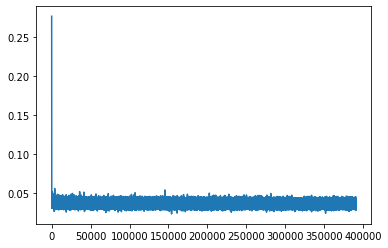

In [ ]:
plt.plot(raw_losses)

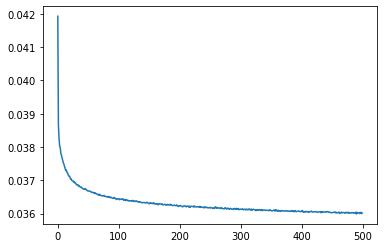

In [ ]:
plt.plot(losses)

In [ ]:
net5 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net5 = net5.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_dataset_xtest= lower_resolution(dataset_test, rate=opt.rate)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

100%|██████████| 10000/10000 [00:05<00:00, 1851.83it/s]


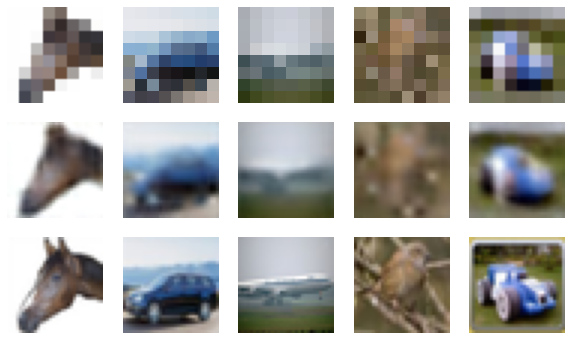

In [ ]:
fig = plt.figure(figsize=(10, 6))
net5.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net5(x)
  img = y[0].permute(1, 2, 0).cpu().detach().numpy()
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

100%|██████████| 10000/10000 [00:05<00:00, 1866.05it/s]


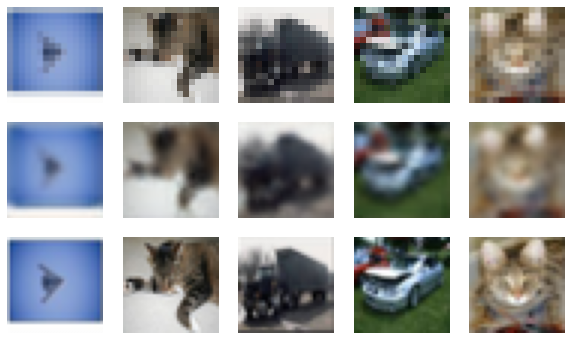

In [ ]:
#50%縮小・拡大した画像を出力してみる
lower_dataset_xtest= lower_resolution(dataset_test, rate=0.5)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

fig = plt.figure(figsize=(10, 6))
net5.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net5(x)
  img = y[0].permute(1, 2, 0).cpu().detach().numpy()
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

###CNN
25%に縮小した画像だと500epoch回しても精度が出ない。

SRCNNの論文で入力画像をBicubic補間して入力にしているので、resize時interpolationをInterpolationMode.BICUBICに変えてみる

とりあえず50%縮小画像から

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：MSELoss（平均二乗誤差）
*   オプティマイザ：Adam
*   transformsで標準化を実施

⇒実行時間：1epochあたり7分(CPU)

　MSELossを見る限り、あまり改善されず
*   T.InterpolationMode.NEAREST：epoch:14, loss:0.007616132333436433
*   T.InterpolationMode.BICUBIC：epoch:14, loss:0.007740177056940315

(net6)

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.5)
parser.add_argument("--model_name", default="SRCNN_BICUBIC")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='SRCNN_BICUBIC', n_epoch=15, rate=0.5)


In [ ]:
# 学習データに適用する前処理
transform = transforms.Compose([
    transforms.ToTensor()                                          # Torchテンソルに変換
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)

In [ ]:
lower_dataset_xtrain = lower_resolution2(dataset_train, rate=opt.rate)
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))

100%|██████████| 50000/50000 [00:43<00:00, 1162.23it/s]


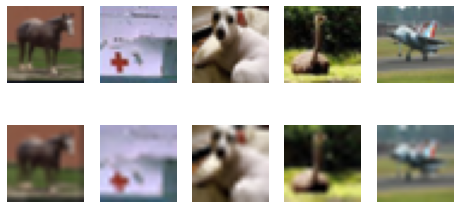

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
B, C, H, W = x_train.shape
input_size=C*H*W

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, input_c=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_c, out_channels=64     , kernel_size=9, padding=9 //2)
        self.conv2 = nn.Conv2d(in_channels=64     , out_channels=32     , kernel_size=5, padding=5 //2)
        self.conv3 = nn.Conv2d(in_channels=32     , out_channels=input_c, kernel_size=5, padding=5 //2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
net = SRCNN(C).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  net.train()
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.to(device)
    target_imgs = target_imgs.to(device)
    batch_size  = train_imgs.shape[0]

    outputs = net(train_imgs)
    loss = criterion(outputs, target_imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [06:52<00:00,  1.89it/s]


epoch:0, loss:0.013696632141966725


100%|██████████| 782/782 [06:50<00:00,  1.91it/s]


epoch:1, loss:0.009319949235952914


100%|██████████| 782/782 [06:55<00:00,  1.88it/s]


epoch:2, loss:0.00882523635681004


100%|██████████| 782/782 [07:02<00:00,  1.85it/s]


epoch:3, loss:0.008530723446113107


100%|██████████| 782/782 [06:54<00:00,  1.89it/s]


epoch:4, loss:0.008383152982019974


100%|██████████| 782/782 [07:14<00:00,  1.80it/s]


epoch:5, loss:0.008255274610860688


100%|██████████| 782/782 [07:33<00:00,  1.73it/s]


epoch:6, loss:0.008166938163268635


100%|██████████| 782/782 [07:38<00:00,  1.70it/s]


epoch:7, loss:0.008072867601290536


100%|██████████| 782/782 [07:15<00:00,  1.80it/s]


epoch:8, loss:0.008016884812842245


100%|██████████| 782/782 [06:53<00:00,  1.89it/s]


epoch:9, loss:0.007959562970106216


100%|██████████| 782/782 [06:57<00:00,  1.87it/s]


epoch:10, loss:0.00789474464638535


100%|██████████| 782/782 [06:56<00:00,  1.88it/s]


epoch:11, loss:0.007867295260462539


100%|██████████| 782/782 [07:05<00:00,  1.84it/s]


epoch:12, loss:0.007819631226870525


100%|██████████| 782/782 [06:52<00:00,  1.90it/s]


epoch:13, loss:0.007777125765200314


100%|██████████| 782/782 [06:51<00:00,  1.90it/s]

epoch:14, loss:0.007740177056940315


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

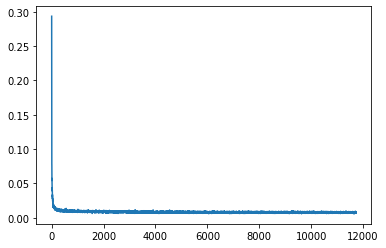

In [ ]:
plt.plot(raw_losses)

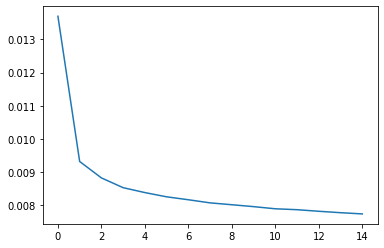

In [ ]:
plt.plot(losses)

In [ ]:
net6 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net6 = net6.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_dataset_xtest= lower_resolution2(dataset_test, rate=opt.rate)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

100%|██████████| 10000/10000 [00:07<00:00, 1340.50it/s]


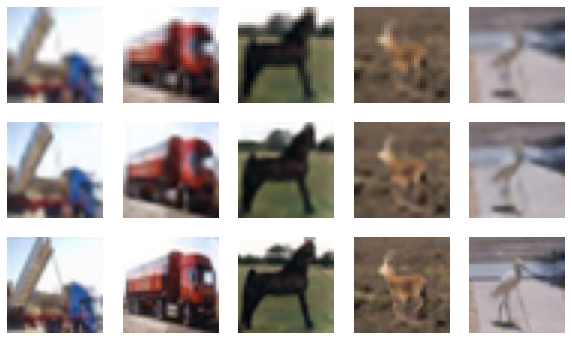

In [ ]:
fig = plt.figure(figsize=(10, 6))
net6.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net6(x)
  img = y[0].permute(1, 2, 0).cpu().detach().numpy()
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()

###CNN
SRCNNの論文で入力画像をBicubic補間して入力にしているので、resize時interpolationをInterpolationMode.BICUBICに変えてみる

25%縮小画像から

*   説明変数（入力）：画質を落とした画像
*   目的変数：Cifar10の元画像
*   損失関数：MSELoss（平均二乗誤差）
*   オプティマイザ：Adam
*   transformsで標準化を実施

⇒実行時間：1epochあたり7分～9分強(CPU)

 　MSELossを見る限り、あまり改善されず
*   InterpolationMode.NEAREST：epoch:14, loss:0.03730532222801386
*   InterpolationMode.BICUBIC：epoch:14, loss:0.03758729950946463

(net7)

In [ ]:
#パラメータ
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--rate", type=float, default=0.25)
parser.add_argument("--model_name", default="SRCNN_BICUBIC")
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, lr=0.001, model_name='SRCNN_BICUBIC', n_epoch=15, rate=0.25)


In [ ]:
# 学習データに適用する前処理
transform = transforms.Compose([
    transforms.ToTensor()                                          # Torchテンソルに変換
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      # 標準化
])
dataset_train = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=True,
    download=False, transform=transform
)

In [ ]:
lower_dataset_xtrain = lower_resolution2(dataset_train, rate=opt.rate)
loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)
x_train, x_target = next(iter(loader_xtrain))

100%|██████████| 50000/50000 [00:40<00:00, 1245.35it/s]


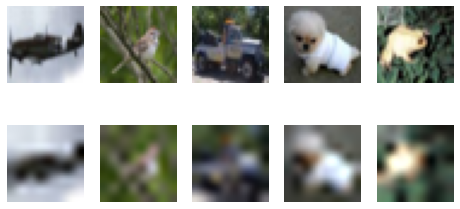

In [ ]:
plt.figure(figsize=(8, 4))
for i in range(5):
  # 元画像
  img = np.transpose(x_target[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 画質を落とした画像
  img = np.transpose(x_train[i], (1, 2, 0))
  img =  img / 2 + 0.5     # unnormalize
  plt.subplot(2, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
plt.show()

In [ ]:
B, C, H, W = x_train.shape
input_size=C*H*W

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, input_c=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_c, out_channels=64     , kernel_size=9, padding=9 //2)
        self.conv2 = nn.Conv2d(in_channels=64     , out_channels=32     , kernel_size=5, padding=5 //2)
        self.conv3 = nn.Conv2d(in_channels=32     , out_channels=input_c, kernel_size=5, padding=5 //2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [ ]:
dataloader = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

loader_xtrain = torch.utils.data.DataLoader(lower_dataset_xtrain, batch_size=opt.batch_size, shuffle=True)

In [ ]:
net = SRCNN(C).to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=opt.lr)

In [ ]:
losses = []     #各epochの平均lossを格納
raw_losses = [] #各画像ごとのlossを格納
for epoch in range(opt.n_epoch):
  net.train()
  running_loss = 0.0
  for i, (train_imgs, target_imgs)  in enumerate(tqdm.tqdm(dataloader, position=0)): #tqdm:プログレスバー
    train_imgs  = train_imgs.to(device)
    target_imgs = target_imgs.to(device)
    batch_size  = train_imgs.shape[0]

    outputs = net(train_imgs)
    loss = criterion(outputs, target_imgs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #損失集計、格納
    running_loss += loss.item() #epochごとの損失を集計
    raw_losses.append(loss.item()) #各データごとの損失を格納
  running_loss /= len(dataloader) #1epochの平均損失を算出
  print("epoch:{}, loss:{}".format(epoch, running_loss))

  losses.append(running_loss)

100%|██████████| 782/782 [07:09<00:00,  1.82it/s]


epoch:0, loss:0.04221468575089179


100%|██████████| 782/782 [07:45<00:00,  1.68it/s]


epoch:1, loss:0.038940515300101786


100%|██████████| 782/782 [07:17<00:00,  1.79it/s]


epoch:2, loss:0.03856058806285757


100%|██████████| 782/782 [07:10<00:00,  1.82it/s]


epoch:3, loss:0.03834039837484012


100%|██████████| 782/782 [09:10<00:00,  1.42it/s]


epoch:4, loss:0.038205506013291875


100%|██████████| 782/782 [08:24<00:00,  1.55it/s]


epoch:5, loss:0.0380860494182962


100%|██████████| 782/782 [09:18<00:00,  1.40it/s]


epoch:6, loss:0.03799700314926979


100%|██████████| 782/782 [07:38<00:00,  1.71it/s]


epoch:7, loss:0.03792181333093463


100%|██████████| 782/782 [07:24<00:00,  1.76it/s]


epoch:8, loss:0.03786156710732699


100%|██████████| 782/782 [07:44<00:00,  1.69it/s]


epoch:9, loss:0.03779055786264293


100%|██████████| 782/782 [06:57<00:00,  1.87it/s]


epoch:10, loss:0.037754171704182694


100%|██████████| 782/782 [07:17<00:00,  1.79it/s]


epoch:11, loss:0.03768673241900666


100%|██████████| 782/782 [07:01<00:00,  1.86it/s]


epoch:12, loss:0.03764171203803223


100%|██████████| 782/782 [07:05<00:00,  1.84it/s]


epoch:13, loss:0.037609860884583055


100%|██████████| 782/782 [07:10<00:00,  1.82it/s]

epoch:14, loss:0.03758729950946463


In [ ]:
torch.save(net, '/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))

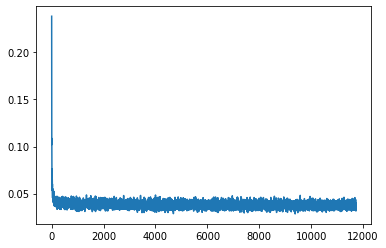

In [ ]:
plt.plot(raw_losses)

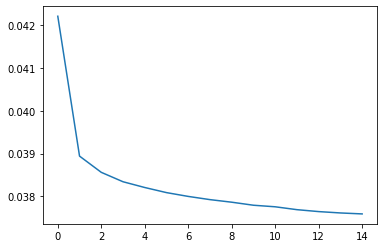

In [ ]:
plt.plot(losses)

In [ ]:
net7 = torch.load('/content/drive/MyDrive/Ecode/model/{}_{}_{}.pt'.format(opt.model_name, opt.rate, opt.n_epoch))
net7 = net7.to(device)

In [ ]:
dataset_test = torchvision.datasets.CIFAR10(
    root='/content/drive/MyDrive/Ecode/data', train=False,
    download=False, transform=transform
)
lower_dataset_xtest= lower_resolution2(dataset_test, rate=opt.rate)
loader_xtest = torch.utils.data.DataLoader(lower_dataset_xtest, batch_size=len(dataset_test), shuffle=True)
x_test, y_target = next(iter(loader_xtest))

100%|██████████| 10000/10000 [00:07<00:00, 1284.87it/s]


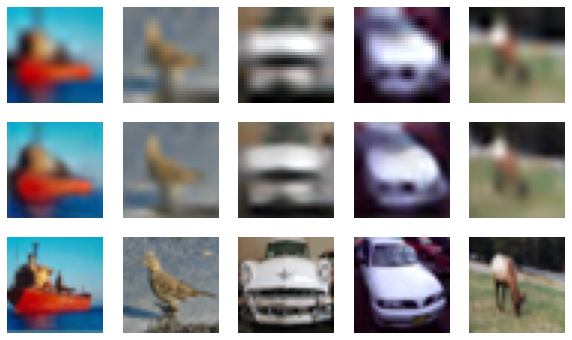

In [ ]:
fig = plt.figure(figsize=(10, 6))
net7.eval()
for i in range(5):
  # 入力画像
  img = np.transpose(x_test[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+1)
  plt.axis("off")
  plt.imshow(img)
  # 出力画像
  x = x_test[i].to(device)
  x = x.unsqueeze(0)      #unsqueeze:指定した位置にサイズ1の次元を挿入 先頭0にバッチサイズ追加
  y = net7(x)
  img = y[0].permute(1, 2, 0).cpu().detach().numpy()
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+6)
  plt.axis("off")
  plt.imshow(img)
  # 元画像
  img = np.transpose(y_target[i], (1, 2, 0))
  img = img / 2 + 0.5     # unnormalize
  plt.subplot(3, 5, i+11)
  plt.axis("off")
  plt.imshow(img)
plt.show()